<a href="https://colab.research.google.com/github/cybunayog/CS125-Midterm-Review-Code/blob/master/StyleGan2_v17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep
## Save dataset into Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Clone Repo and install resize module

In [2]:
# Clone the repo (DO THIS ONCE)
!git clone https://github.com/cybunayog/stylegan2.git

# Install python-resize-image (RUN ONCE AND COMMENT)
!pip install python-resize-image

Cloning into 'stylegan2'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 133 (delta 1), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (133/133), 637.25 KiB | 13.85 MiB/s, done.
Resolving deltas: 100% (59/59), done.


## Tensorflow & GPU Check

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
import os

# Verify if repo has been cloned
print("List directory")
!ls /content/stylegan2
print("\n")

# Make sure you use tensoflow version 1
print('Tensorflow version: {}'.format(tf.__version__) )

# Use '%' prefix in colab or run this in command line
%cd /content/stylegan2

# Test if CPU, GPU, and Tensorflow is recognized
!nvcc test_nvcc.cu -o test_nvcc -run
print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
List directory
dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  StyleGan2_v17.ipynb
Dockerfile	 pretrained_networks.py  run_metrics.py    test_nvcc.cu
docs		 projector.py		 run_projector.py  training


Tensorflow version: 1.15.2
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-a0a767b1-6e93-70ea-d146-7a39b94227ee)
GPU Identified at: /device:GPU:0


## Extract Custom Dataset from G Drive to Colab

In [4]:
# Run once
## There are 63565 images/seeds
!unrar x "/content/drive/MyDrive/Colab Notebooks/animeDataset.rar" "/content/custom_data/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/custom_data/images/62765_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62766_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62767_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62768_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62769_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/6276_2003.jpg                     92%  OK 
Extracting  /content/custom_data/images/62770_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62771_2019.jpg                    93%  OK 
Extracting  /content/custom_data/images/62772_2019.jpg                    93%  OK 
Extracting  /content/custom_data/images/62773_2019.jpg                    93%  OK 
Extracting  /content/custom_d

## Resize Images to prep for Training

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from PIL import Image
from tqdm import tqdm
import cv2
from resizeimage import resizeimage

# From the custom dataset
path = '/content/custom_data/images/'
for filename in tqdm(os.listdir(path), desc='reading images...'):
  image = Image.open(path+filename)
  image = image.resize((64, 64))
  image.save(path+filename, image.format)

## Convert Custom Images to tfrecords

This is required for training the stylegan

In [ ]:
! python /content/stylegan2/dataset_tool.py create_from_images /content/stylegan2/datasets/anime-dataset /content/custom_data/images/

# Train Dataset & Create Models
### This usually takes the longest
### Based on total kimg (iterations or epochs): The higher kimg, the longer it takes for the model to train

#### Current training: 480 iterations

In [ ]:
# Recommended to go 10000 kimg for better results
! python /content/stylegan2/run_training.py --num-gpus=1 --data-dir=/content/stylegan2/datasets --config=config-f --dataset=anime-dataset --result-dir=/content/results --metrics=None --total-kimg=1000 #--mirror-augment=true 

Local submit - run_dir: /content/results/00000-stylegan2-anime-dataset-1gpu-config-f
dnnlib: Running training.training_loop.training_loop() on localhost...
Streaming data using training.dataset.TFRecordDataset...
tcmalloc: large alloc 4294967296 bytes == 0x56257303c000 @  0x7f00834cc001 0x7f007ffb054f 0x7f0080000b58 0x7f0080004b17 0x7f00800a3203 0x56256ce390e4 0x56256ce38de0 0x56256cead6f5 0x56256cea7e0d 0x56256ce3b02c 0x56256ce7bd39 0x56256ce78c84 0x56256ce3b231 0x56256ceaa1e6 0x56256cea7b0e 0x56256cd79e2b 0x56256ceaa1e6 0x56256cea7b0e 0x56256cd79e2b 0x56256ceaa1e6 0x56256ce3a69a 0x56256cea8a45 0x56256ce3a69a 0x56256cea8c9e 0x56256cea7b0e 0x56256cd79e2b 0x56256ceaa1e6 0x56256cea7b0e 0x56256cd79e2b 0x56256ceaa1e6 0x56256ce3a69a
tcmalloc: large alloc 4294967296 bytes == 0x56267303c000 @  0x7f00834ca1e7 0x7f007ffb046e 0x7f0080000c7b 0x7f008000135f 0x7f00800a3103 0x56256ce390e4 0x56256ce38de0 0x56256cead6f5 0x56256cea7b0e 0x56256ce3a77a 0x56256cea986a 0x56256cea7b0e 0x56256ce3a77a 0x56256

# Using generated model
## Get pretrained model from personal drive
### I was only able to iterate around 400 kimg/epochs

In [7]:
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000000.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000160.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000320.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000480.pkl' .

## Project Generated & Real Images
### Get trained model

In [8]:
! python /content/stylegan2/run_projector.py project-generated-images --network=/content/stylegan2/network-snapshot-000480.pkl --seeds=1,3,5 

Local submit - run_dir: results/00000-project-generated-images
dnnlib: Running run_projector.project_generated_images() on localhost...
Loading networks from "/content/stylegan2/network-snapshot-000480.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Projecting seed 1 (0/3) ...
Projecting seed 3 (1/3) ...
Projecting seed 5 (2/3) ...
dnnlib: Finished run_projector.project_generated_images() in 2m 45s.


## Generate Random images without truncation

In [10]:
# Generate results from training
! python /content/stylegan2/run_generator.py generate-images --seeds=0-49 --network=/content/stylegan2/network-snapshot-000480.pkl

Local submit - run_dir: results/00002-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "/content/stylegan2/network-snapshot-000480.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for seed 0 (0/50) ...
Generating image for seed 1 (1/50) ...
Generating image for seed 2 (2/50) ...
Generating image for seed 3 (3/50) ...
Generating image for seed 4 (4/50) ...
Generating image for seed 5 (5/50) ...
Generating image for seed 6 (6/50) ...
Generating image for seed 7 (7/50) ...
Generating image for seed 8 (8/50) ...
Generating image for seed 9 (9/50) ...
Generating image for seed 10 (10/50) ...
Generating image for seed 11 (11/50) ...
Generating image for seed 12 (12/50) ...
Generating image for seed 13 (13/50) ...
Generating image for seed 14 (14/50) ...
Generating image for seed 15 (15/50) ...
Generati

## Display images setup

In [11]:
import pretrained_networks
network_pkl = '/content/stylegan2/network-snapshot-000480.pkl'

# It returns 3 networks, we will be mainly using Gs
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


## Generate Random Vectors

In [20]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

## Helper Functions to display results

In [21]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# Get tf noise variables, for the stochastic variation
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# Trunctation psi value needed for the truncation trick
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    # Return array of PIL.Image
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

### Pre-Trained Results

9it [00:00, 95.52it/s]

[ 47680 330054 823279 100514 130643 526426 802056 294684  98704]


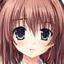

In [44]:
# generate 9 random seeds
seeds = np.random.randint(1000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, 0.5)
imgs[0]

## Pre-Trained Results Loop

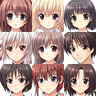

In [45]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
  w, h = images[0].size
  w = int(w * scale)
  h = int(h * scale)
  height = rows * h
  cols = ceil(len(images) / rows)
  width = cols * w
  canvas = PIL.Image.new('RGBA', (width, height), 'white')

  for i, img in enumerate(images):
    img = img.resize((w, h), PIL.Image.ANTIALIAS)
    canvas.paste(img, (w * (i % cols), h * (i // cols)))
  
  return canvas

createImageGrid(imgs, scale=0.5 ,rows=3)

## Interpolate between two values of the Z vectors


In [33]:
def interpolate(zs, steps):
  out = []
  for i in range(len(zs) - 1):
    for index in range(steps):
      fraction = index / float(steps)
      out.append(zs[i + 1] * fraction + zs[i] * (1 - fraction))
  return out

## Results of Interpolation

14it [00:00, 100.04it/s]


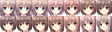

In [46]:
seeds = np.random.randint(10000000, size=3)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=2)